## Cusom datasets

This part will focus on creating a dataset and then predicting on it
The dataset chosen is a subset of the Food101 dataset and contains 3 different classes: 
* Pizza
* Steak
* Sushi

### Imports 

In [ ]:
# Imports
import torch as pt
from torch import nn

print(f"Torch version: {pt.__version__}")


In [ ]:
# Setup device agnostic code
device = 'cuda' if pt.cuda.is_available() else 'cpu'
print(f"device: {device}")

### Downloading a custom dataset

In [ ]:
from pathlib import Path
import importLib
from sys import path
import zipfile


# Create directory
data_path = Path(f"{path[0]}/data")
image_path = data_path / 'pizza_steak_sushi'
if image_path.exists():
    print('Already exists')
else:
    image_path.mkdir(parents=True)


# Download pizza, steak and sushi data
# open skapar en zip fil som sedan fylls genom request
importLib.import_from_github('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',directory=data_path)
with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data')
    zip_ref.extractall(image_path)
    #request = requests.get()



### Become one with the data

In [ ]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path and returns its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
walk_through_dir(image_path)

In [ ]:
# Setup training and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

### Visualize an image

Let's write some code to:
1. Get all the image paths (pathlib)
2. Pick a random path
3. Get the image class name, by looking at the pathlib.Path.parent.stem
4. Since we are working with images, we will open it with PIL
5. Show image and print metadata


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from torchvision import transforms
from PIL import Image
# Set seed
seed = None
random.seed(None)

# 1. Get all image paths
image_path_list = (list(image_path.glob('*/*/*.jpg'))) # glob together every image with a certain pattern
print(f'This globs together all the {len(image_path_list)} images inside pizza_steak_sushi')
random_image_path = random.choice(image_path_list)
print("Chosen random image: "+random_image_path.name)
print('Class is a: '+random_image_path.parent.stem)
img = Image.open(random_image_path)
print(f"Height: {img.height}")
print(f"Width: {img.width}")
img

In [ ]:
tensor = transforms.Compose([transforms.PILToTensor()])(img)
print(tensor.shape)
tensor = tensor.permute(2, 1,0)
# plot image
plt.title(f'Random image of {random_image_path.parent.stem}')
plt.imshow(tensor)
plt.axis(False)

### Transforming data

Before we can use our data:
1. Turn target data to tensors, in this case: Pictures -> tensors
2. Turn it to a `torch.utils.data.Dataset` and subsequently (afterwards) into a `torch.utils.data.Dataloader`, (Batched dataset)

Information and help regarding transforms: https://pytorch.org/vision/stable/transforms.html

In [ ]:
import torch as pt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write a transform for image
# transforms.Compose is similar to nn.Sequential where it can hold many different transforms
data_transform = transforms.Compose([
    # Resize our images to a set size to ensure compability with our modules shape handeling
    transforms.Resize(size=(64, 64)),
    # Flip the image half of the time it goes through this pipeline
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

(-0.5, 63.5, 63.5, -0.5)

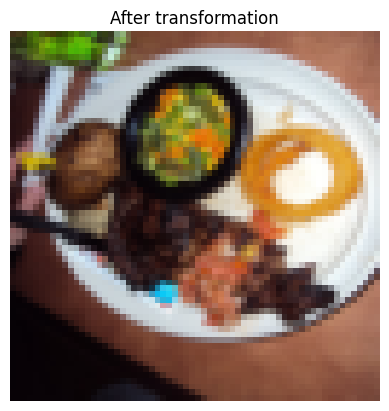

In [11]:
plt.title('After transformation')
plt.imshow(data_transform(img).permute(2,1,0))
plt.axis(False)

In [12]:
def plot_transformed_images(image_paths:str, transform:transforms, n:int=3, seed:int=None):
    """Plot difference between transformed images and normal
    
    args:
        image_paths (Sequence[Path()]): List of image file paths.
        transform (torchvision.transforms): Image transformation object.
        num_images (int, optional): Number of images to display. Default is 3.
        seed (int, optional): Random seed for image selection. Default is None."""
    from random import sample, seed as random_seed
    random_seed(seed)
    image_paths = sample(image_paths,k=n)
    fig, ax = plt.subplots(nrows=len(image_paths),ncols=2)
    for i,img_path in enumerate(image_paths):
        with Image.open(img_path) as f:
            ax[i,0].imshow(f)
            ax[i,1].imshow(transform(f).permute(2,1,0))
            ax[i,0].axis(False)
            ax[i,0].set_title(f"Size: {f.size}")
            ax[i,1].axis(False)
            ax[i,1].set_title(f'Size: ({str(transform(f).permute(2,1,0).size())[12:-2]})')

    plt.tight_layout(w_pad=-10)

    plt.subplots_adjust(top=0.8)
    plt.suptitle('Images\nOriginal    Transformed', fontsize=20)
    plt.show()

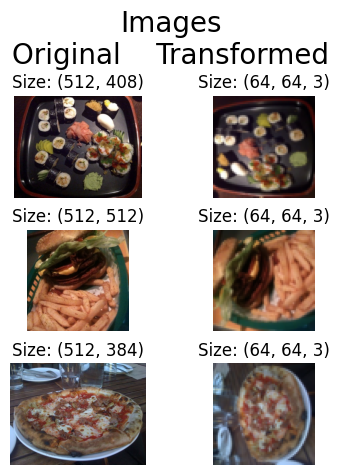

In [13]:
plot_transformed_images(image_path_list, data_transform,3,seed=42)

### Loading all of our images


Option 1: Loading image data usin `ImageFolder`: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

Option 2: Do it by yourself


In [21]:
from torchvision import datasets
# the ImageFolder class makes a division automaticly without having to hardcode it, because we have our data already structured in the pytorch style with first the dataset then train and test dir with pictures in them 
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, # a transform for the data
                                  target_transform=None, # a transform for the targets/labels
                                  )
test_data = datasets.ImageFolder(root=test_dir, 
                                  transform=data_transform, # a transform for the data
                                  target_transform=None, # a transform for the targets/labels
                                  )
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: c:\Users\22gusgam\Desktop\k\PyTorch\04\data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: c:\Users\22gusgam\Desktop\k\PyTorch\04\data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

Text(0.5, 1.0, 'pizza')

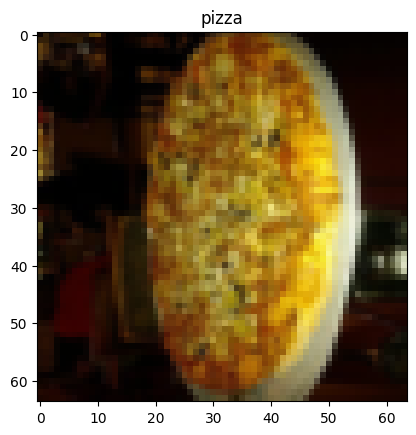

In [64]:
plt.imshow(test_data[0][0].permute(2,1,0))
plt.title(test_data.classes[test_data[0][1]])